In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import warnings
warnings.filterwarnings('ignore')

In [5]:
#Load dataset
df = pd.read_csv('data/daily_traffic.csv')
df.head()

,date_time,traffic_volume
0,9/29/2016 17:00,5551.0
1,9/29/2016 18:00,4132.0
2,9/29/2016 19:00,3435.0
3,9/29/2016 20:00,2765.0
4,9/29/2016 21:00,2443.0


In [6]:
#Convert to TimeSeries as required by darts
series = TimeSeries.from_dataframe(df, time_col='date_time')
series.head()

<TimeSeries (DataArray) (date_time: 5, component: 1, sample: 1)>
array([[[5551.]],

       [[4132.]],

       [[3435.]],

       [[2765.]],

       [[2443.]]])
Coordinates:
  * date_time  (date_time) datetime64[ns] 2016-09-29T17:00:00 ... 2016-09-29T...
  * component  (component) object 'traffic_volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

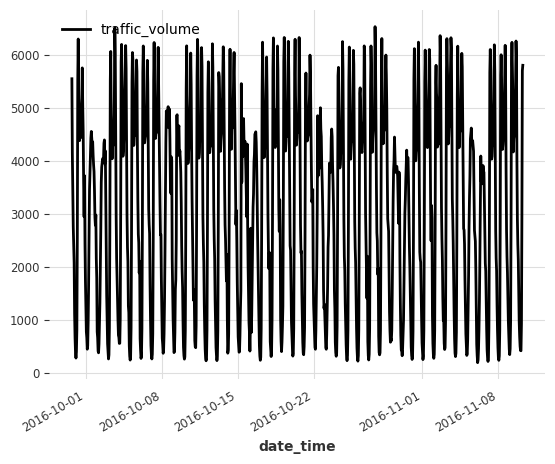

In [7]:
#Plot Series
series.plot()


In [12]:
df.describe()

,traffic_volume
count,999.000000
mean,3187.463964
std,1878.983227
min,194.000000
25%,1291.000000
50%,3590.000000
75%,4639.000000
max,6534.000000


In [13]:
#Check if a seasonal period has statistical significance
from darts.utils.statistics import check_seasonality

is_daily_seasonal, daily_period = check_seasonality(series, m=24, max_lag=400, alpha=0.05)
is_weekly_seasonal, weekly_period = check_seasonality(series, m=168, max_lag=400, alpha=0.05)

print(f'Daily seasonality: {is_daily_seasonal} - period = {daily_period}')
print(f'Weekly seasonality: {is_weekly_seasonal} - period = {weekly_period}')

Daily seasonality: True - period = 24
Weekly seasonality: True - period = 168


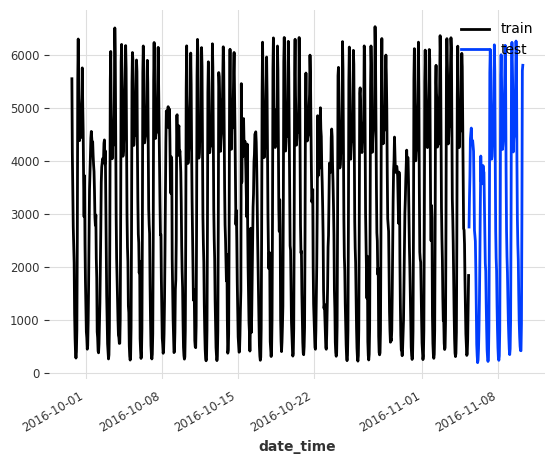

In [17]:
#Split Dataset
train, test = series[:-120], series[-120:]

train.plot(label='train')
test.plot(label='test')

In [20]:
#Define a baseline Model
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=168)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(120)

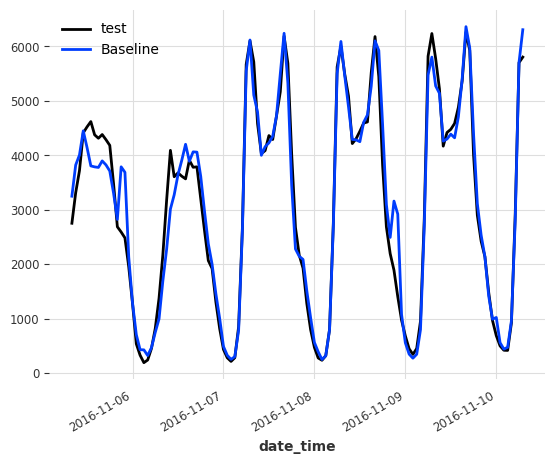

In [23]:
#Visualize the forecast from baseline model
test.plot(label='test')
pred_naive.plot(label='Baseline')

In [24]:
from darts.metrics import mae

naive_mae = mae(test, pred_naive)

print(naive_mae)

249.09166666666667


### N-Beats without covariates

In [25]:
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

In [26]:
#Scale the data between 0 and 1
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

In [36]:
#Initialize N-BEATS Model
nbeats = NBEATSModel(
    input_chunk_length=168, 
    output_chunk_length=24,
    generic_architecture=True,
    random_state=42)

In [37]:
nbeats.fit(
    scaled_train,
    epochs=32)

RuntimeError: No precision set

In [38]:
scaled_pred_nbeats = nbeats.predict(n=120)

pred_nbeats = train_scaler.inverse_transform(scaled_pred_nbeats)

AttributeError: 'NoneType' object has no attribute 'set_predict_parameters'